# Implementing ANNs with TensorFlow
# Assignment 6: Long Short-Term Memory
# Group 12: Renato Garita Figueiredo, Hamza Kebiri, Turan Orujlu

### Imports

In [2]:
import os
import numpy as np
import tensorflow as tf
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

### Data

In [3]:
class IMDB:
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data, self._training_labels = self._load_data("train")
        self._test_data, self._test_labels = self._load_data("test")
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 7, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
        
        joined_written_ratings = [word for text in self._training_data for word in text]
        print("Unique words: " + str(len(Counter(joined_written_ratings))))
        print("Mean length: " + str(np.mean([len(text) for text in self._training_data])))
        
    
    def _load_data(self, data_set_type):
        data = []
        labels = []
        # Iterate over conditions
        for condition in ["neg", "pos"]:
            directory_str = os.path.join(self._directory, "aclImdb", data_set_type, condition)
            directory = os.fsencode(directory_str)
        
            for file in os.listdir(directory):
                filename = os.fsdecode(file)
                
                label = 0 if condition == "neg" else 1
                labels.append(label)
                
                # Read written rating from file
                with open(os.path.join(directory_str, filename), encoding="utf8") as fd:
                    written_rating = fd.read()
                    written_rating = written_rating.lower()
                    tokenizer = RegexpTokenizer(r'\w+')
                    written_rating = tokenizer.tokenize(written_rating)
                    data.append(written_rating)
                
        return np.array(data), np.array(labels)
    
    def create_dictionaries(self, vocabulary_size, cutoff_length):
        joined_written_ratings = [word for text in self._training_data for word in text]
        words_and_count = Counter(joined_written_ratings).most_common(vocabulary_size - 2)
        
        word2id = {word: word_id for word_id, (word, _) in enumerate(words_and_count, 2)}
        word2id["_UNKNOWN_"] = 0
        word2id["_NOT_A_WORD_"] = 1
        
        id2word = dict(zip(word2id.values(), word2id.keys()))
        
        self._word2id = word2id
        self._id2word = id2word
        
        self._training_data = np.array([self.words2ids(text[:cutoff_length]) for text in self._training_data])
        self._validation_data = np.array([self.words2ids(text[:cutoff_length]) for text in self._validation_data])
        self._test_data = np.array([self.words2ids(text[:cutoff_length]) for text in self._test_data])
        
    
    def words2ids(self, words):
        if type(words) == list or type(words) == range or type(words) == np.ndarray:
            return [self._word2id.get(word, 0) for word in words]
        else:
            return self._word2id.get(words, 0)
    
    def ids2words(self, ids):
        if type(ids) == list or type(ids) == range or type(ids) == np.ndarray:
            return [self._id2word.get(wordid, "_UNKNOWN_") for wordid in ids]
        else:
            return self._id2word.get(ids, "_UNKNOWN_")
    
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]        
        
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def slice_batch(self, batch, slice_size):
        max_len = np.max([len(sample) for sample in batch])
        steps = int(np.ceil(max_len / slice_size))
        max_len = slice_size * steps
        
        # Resize all samples in batch to same size
        batch_size = len(batch)
        buffer = np.ones((batch_size, max_len), dtype = np.int32)
        for i, sample in enumerate(batch):
            buffer[i, 0:len(sample)] = sample
        
        for i in range(steps):
            on = i * slice_size
            off = on + slice_size
            yield buffer[:, on:off]
        
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n

### Hyperparameters

In [4]:
# LSTM memory size
lstm_memory_size = 64
# Embedding size
embedding_size = 64
# Vocabulary size
vocabulary_size = 20000
# Review cutoff length
cutoff_length =300
# Subsequence length
sequence_length = 100
# Batch size
batch_size = 250
# Epochs
epochs = 2
# Learning rate
learning_rate = 0.03
# Dropout rate
keep_prob = 0.85

### Data preparation

In [5]:
# Load the data using the provided helper class
imdb_data = IMDB(os.getcwd())

# create a word <--> id mapping
imdb_data.create_dictionaries(vocabulary_size, cutoff_length)

Unique words: 70316
Mean length: 241.894582108


### Test the mapping

In [6]:
imdb_data.ids2words(imdb_data.words2ids(['movie', 'dog', 'cat', 'unknown', 'jumanji']))

['movie', 'dog', 'cat', 'unknown', '_UNKNOWN_']

### Embedding

In [7]:
# Placeholder for word ids
word_id_sequence = tf.placeholder(tf.int32, shape=[batch_size, sequence_length], name='word_id_sequence')

with tf.variable_scope("embedding"):
    # Create a word-embedding of size vocabulary size x embedding size
    initializer = tf.random_uniform_initializer(-1.0, 1.0)
    embeddings = tf.get_variable("embeddings", [vocabulary_size, embedding_size], initializer = initializer)
    # Given a tensor of sequence of word ids, retrieve the respective embedding
    sequences = tf.nn.embedding_lookup(embeddings, word_id_sequence)

### LSTM

In [8]:
# Placeholders for the complement of the dropout probability, the cell state, and the hidden state
keep_probability = tf.placeholder(tf.float32, shape=())
cell_state = tf.placeholder(tf.float32, shape=[batch_size, lstm_memory_size], name='cell_state')
hidden_state = tf.placeholder(tf.float32, shape=[batch_size, lstm_memory_size], name='hidden_state')

with tf.variable_scope("lstm"):
    # Create LSTM cell isntance
    cell = tf.nn.rnn_cell.BasicLSTMCell(lstm_memory_size)
    
    # Possibly add dropout between recurrent steps
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = keep_probability)
    
    # Create zero state and initialize hidden and cell state from placeholder values
    zero_state = cell.zero_state(batch_size, tf.float32)
    state = tf.nn.rnn_cell.LSTMStateTuple(c = cell_state, h = hidden_state)
    
    # tf.nn.static_rnn expects list of time step vectors
    sequences = tf.unstack(sequences, num = sequence_length, axis = 1)
    
    # Unroll the model, returns list of outputs and final cell state
    outputs, state = tf.nn.static_rnn(cell, sequences, initial_state = state)
    
    # Recreate tensor from list
    outputs = tf.reshape(tf.concat(outputs, 1), [batch_size, sequence_length, lstm_memory_size])
    
    # Take mean of the output sequence
    output = tf.reduce_mean(outputs, 1)

### FFNN

In [9]:
with tf.variable_scope("ffnn"):
    # Create weights and biases for FFNN
    initializer = tf.truncated_normal_initializer(stddev = 2.0 / lstm_memory_size)
    ffnn_weights = tf.get_variable("weights", [lstm_memory_size, 1], tf.float32, initializer)
    ffnn_biases = tf.get_variable("biases", [1], initializer = tf.zeros_initializer())
    
    # Calculate the logits of FFNN
    logits = tf.matmul(output, ffnn_weights) + ffnn_biases

### Binary Cross Entropy

In [10]:
# PLaceholder for training labels
train_labels = tf.placeholder(tf.float32, shape=[batch_size, 1], name='train_labels')

with tf.variable_scope("binary_cross_entropy"):
    # Define loss
    sigmoid_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=train_labels, logits=logits)
    sigmoid_cross_entropy = tf.reduce_mean(sigmoid_cross_entropy)
    
    # Accuracy as the percentage of correct guesses
    correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.nn.sigmoid(logits), 0.5), tf.float32), train_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Add summary node for sigmoid cross entropy
    tf.summary.scalar("sigmoid_cross_entropy", sigmoid_cross_entropy)
    
    # Add summary node for accuracy
    tf.summary.scalar("accuracy", accuracy)
    
with tf.variable_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_step = optimizer.minimize(sigmoid_cross_entropy)

### Train the network

In [11]:
# Make all summary nodes dependent of a single node
merged_summaries = tf.summary.merge_all()

# Create a summary file writer for training summaries
train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())

# Create new session and evaluate graph
session = tf.InteractiveSession()
    
# step counter
step = 0

# Initialize the variables
session.run(tf.global_variables_initializer())

print('Training ...')

for epoch in range(epochs):

    # print the epoch number
    print('Epoch:', epoch + 1)

    for id_seqs, labels in imdb_data.get_training_batch(batch_size):
        labels =  np.expand_dims(labels, axis=1).astype(np.float32)
        # Get initial hidden and cell state
        _state = session.run(zero_state)
        
        for subsequence in imdb_data.slice_batch(id_seqs, sequence_length):
            # Get state of last step
            _state, _summaries, _ = session.run(
                [state, merged_summaries, training_step],
                feed_dict = {
                    word_id_sequence: subsequence,
                    train_labels: labels,
                    keep_probability: keep_prob,
                    cell_state: _state.c,
                    hidden_state: _state.h
                }
            )
            
            # Increment the step counter
            step += 1
            
            # Write summary to summary file
            train_writer.add_summary(_summaries, step)
            
        # Print the validation accuracy after every 15 steps
        if step % 15 == 0:
            _val_accuracy = 0.0
            _val_step = 0
            for val_id_seqs, val_labels in imdb_data.get_validation_batch(batch_size):
                val_labels =  np.expand_dims(val_labels, axis=1).astype(np.float32)
                # Get initial hidden and cell state
                _val_state = session.run(zero_state)

                for val_subsequence in imdb_data.slice_batch(val_id_seqs, sequence_length):
                    # Get state of last step
                    _val_state, _accuracy, = session.run(
                        [state, accuracy],
                        feed_dict = {
                            word_id_sequence: val_subsequence,
                            train_labels: val_labels,
                            keep_probability: keep_prob,
                            cell_state: _val_state.c,
                            hidden_state: _val_state.h
                        }
                    )
                    _val_accuracy += _accuracy
                    _val_step += 1
            _val_accuracy /= _val_step

            print('Validation accuracy at step %d: %f' % (step, _val_accuracy))            

print('Training is over!')


Training ...
Epoch: 1
Validation accuracy at step 15: 0.497905
Validation accuracy at step 30: 0.527905
Validation accuracy at step 45: 0.681143
Validation accuracy at step 60: 0.738667
Validation accuracy at step 75: 0.766476
Validation accuracy at step 90: 0.785524
Validation accuracy at step 105: 0.793810
Validation accuracy at step 120: 0.804190
Validation accuracy at step 135: 0.811143
Validation accuracy at step 150: 0.823238
Validation accuracy at step 165: 0.820286
Validation accuracy at step 180: 0.794286
Validation accuracy at step 195: 0.828857
Validation accuracy at step 210: 0.817048
Validation accuracy at step 225: 0.832857
Validation accuracy at step 240: 0.828476
Validation accuracy at step 255: 0.828095
Epoch: 2
Validation accuracy at step 270: 0.830476
Validation accuracy at step 285: 0.817048
Validation accuracy at step 300: 0.830571
Validation accuracy at step 315: 0.822952
Validation accuracy at step 330: 0.832000
Validation accuracy at step 345: 0.835238
Validatio

### t-SNE

In [12]:
# Placeholder for word ids
word_ids = tf.placeholder(tf.int32, shape=[None], name='word_ids')

# Given a tensor of word ids, retrieve the respective embedding
embed = tf.nn.embedding_lookup(embeddings, word_ids)

# get the embeddings of the whole vocabulary
_embed = session.run(embed, feed_dict={word_ids: list(imdb_data._word2id.values())})

# apply t-SNE
_embed_tsne = TSNE().fit_transform(_embed)

### Annotated scatter plot

<IPython.core.display.Javascript object>


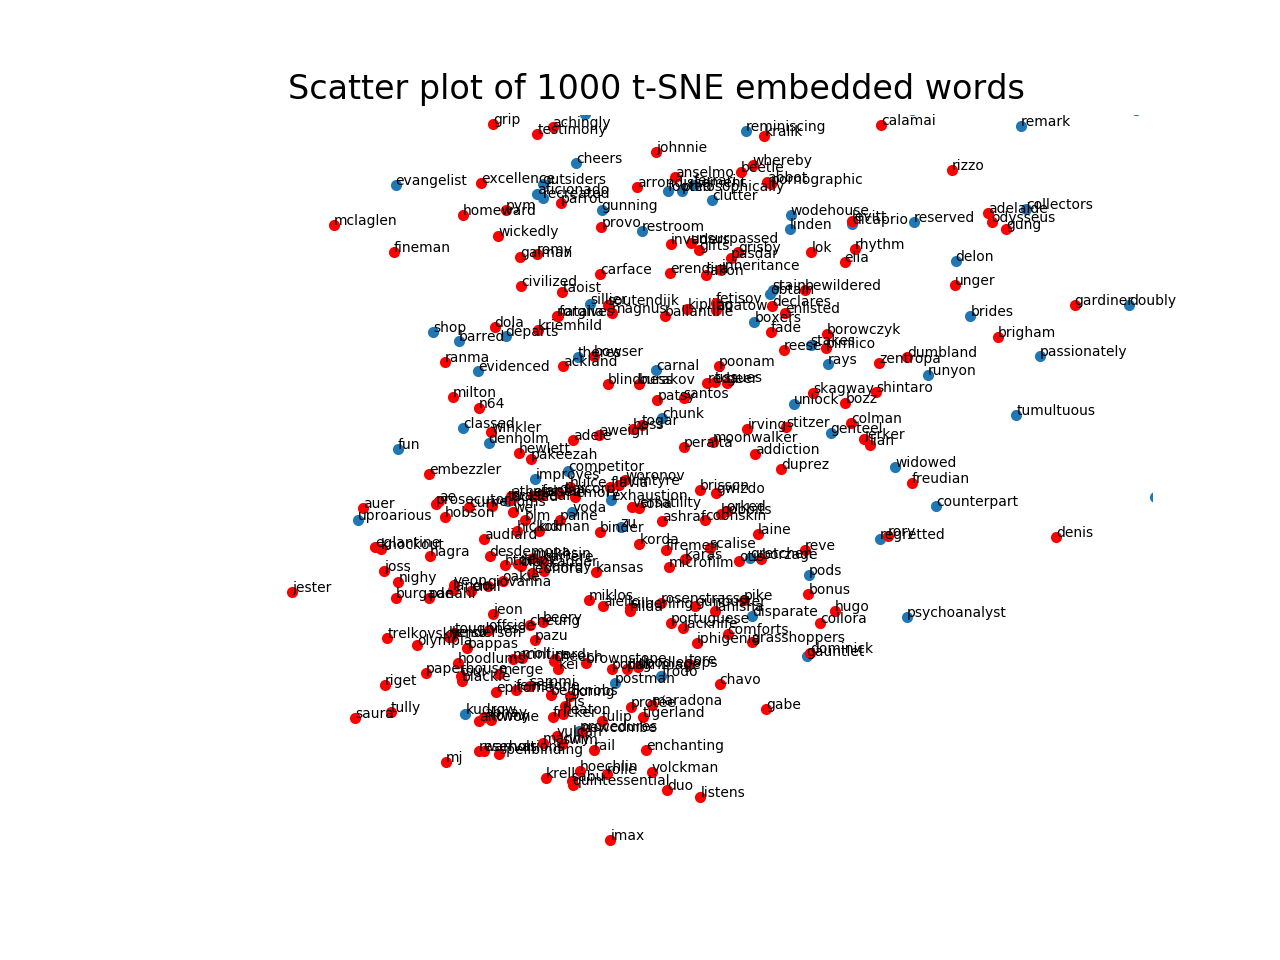

In [13]:
# Sort the word ids based on their relative frequency
# in positively vs negatively labelled word id sequences
pos = np.zeros(len(imdb_data._word2id.values()))
neg = np.zeros(len(pos))
ratio = np.zeros(len(pos))
training_samples_n, _, _ = imdb_data.get_sizes()
id_seqs, labels = next(imdb_data.get_training_batch(training_samples_n))
for i, id_seq in enumerate(id_seqs):
    for id_ in id_seq:
        if labels[i]:
            pos[id_] += 1.00
        else:
            neg[id_] += 1.00
for i in range(len(ratio)):
    if neg[i] == 0:
        ratio[i] = pos[i]
    elif pos[i] == 0:
        ratio[i] = -neg[i]
    else:
        ratio[i] = pos[i]/neg[i]
ratio = np.argsort(ratio)

# 500 relatively most frequent word ids in negatively
# and respectively positively labelled word id sequences
_embed_tsne_neg = _embed_tsne[ratio[:500]]
_embed_tsne_pos = _embed_tsne[ratio[::-1][:500]]

# The words corresponding to the word ids above
_annotations_neg = np.array(list(imdb_data._word2id.keys()))[ratio[:500]]
_annotations_pos = np.array(list(imdb_data._word2id.keys()))[ratio[::-1][:500]]

# Plot the t-SNE embeddings
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(_embed_tsne_neg[:, 0], _embed_tsne_neg[:, 1], marker='.')
ax.scatter(_embed_tsne_pos[:, 0], _embed_tsne_pos[:, 1], marker='.', c='r')
for i, _annotation_neg in enumerate(_annotations_neg):
    ax.annotate(_annotation_neg, xy=_embed_tsne_neg[i], fontsize=5)
for i, _annotation_pos in enumerate(_annotations_pos):
    ax.annotate(_annotation_pos, xy=_embed_tsne_pos[i], fontsize=5)
plt.title('Scatter plot of 1000 t-SNE embedded words')
plt.axis('off')
plt.show()

Blue dots represent the words that appear more frequently in the negative ratings, and red dots in the positive. As you can see, there is no apparent correlation between the color of a dot and its position on the map. However, when we zoom in, the words with a negative connotation (unfortunately, oops, boring, badly, poorly, contrived, moronic, miserable, disgust, weak, horrorfest, uncreative, disgrace, bitterly, blame, unrealistic, etc.) appear to be clustered in the lower right tail of the distribution, and the words with a positive connotation (liberties, refreshing, achievement, kiss, win, brotherly, friendship, helping, vitality, enable, masterpieces, delicious, enthralled, uplifting, etc.) in the upper right tail.

### Test performance

In [14]:
_test_accuracy = 0.0
_test_step = 0
for test_id_seqs, test_labels in imdb_data.get_test_batch(batch_size):
    test_labels =  np.expand_dims(test_labels, axis=1).astype(np.float32)
    # Get initial hidden and cell state
    _test_state = session.run(zero_state)

    for test_subsequence in imdb_data.slice_batch(test_id_seqs, sequence_length):
        # Get state of last step
        _test_state, _accuracy, = session.run(
            [state, accuracy],
            feed_dict = {
                word_id_sequence: test_subsequence,
                train_labels: test_labels,
                keep_probability: keep_prob,
                cell_state: _test_state.c,
                hidden_state: _test_state.h
            }
        )
        _test_accuracy += _accuracy
        _test_step += 1
_test_accuracy /= _test_step

print('Test accuracy: %f' % _test_accuracy)

Test accuracy: 0.806853
